---
title: "Adaptive Discriminator Augmentation Preset"
description: "how to use the AdaptiveDiscriminatorAugmentation API to train Generative Adverserial Networks with limited data"
author:
    - "Dhia naouali"
date: "08-07-2025"
categories:
    - "itermediate"
    - "kornia.augmentation"
    - "Presets"
    - "Data augmentation"
    - "Augmentation container"
    - "2D"
image: "../tutorials/assets/adaptive_discriminator_augmentation_preset.png"
---

<a href="https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/nbs/adaptive_discriminator_augmentation_preset.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in google colab"></a>


## Theory
The core idea of the Adaptive Discriminator Augmentation technique (ADA for short), is applying a series of image augmentations to real and generated images before passing them to the *Discriminator* to make its task *harder*  
Augmentations are applied with a (global) probability `p` (: whether we apply augmentations or not), the series of augmentations we apply are recommended to be selected so the undderlying distribution is still learnable  

we restrict the *Discriminator*'s capacity to identify real images by dynamically updating `p`, i.e: increase the probability of applying augmentations when the *Discriminator* is performing too well (dominating the *Generator*) and vice versa

In [1]:
%%capture
!pip install git+https://github.com/kornia/kornia.git

downloading the images we will use to explore ADA and a batch of 16 images for a dummy training lap for a simple GAN

In [ ]:
import io
import zipfile

import requests


def download_images():
    # kornia panda illustration
    jpg_url = "https://raw.githubusercontent.com/kornia/data/main/panda.jpg"
    jpg_path = "panda.jpg"

    r = requests.get(jpg_url)
    if r.status_code == 200:
        with open(jpg_path, "wb") as f:
            f.write(r.content)
    else:
        print(f"failed to download panda image")

    # a batch of 16 panda images
    zip_url = "https://github.com/kornia/data/raw/main/presets/ada_pandas.zip"
    r = requests.get(zip_url)
    if r.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(r.content)) as zip_ref:
            zip_ref.extractall(".")
    else:
        print(f"failed to download pandas batch of images")


download_images()

in this tutorial, we will primarily use `kornia` and `pytorch`

In [32]:
import os

import kornia
import kornia.augmentation as K
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia.augmentation.presets.ada import AdaptiveDiscriminatorAugmentation
from torch import nn, optim
from tqdm import tqdm

seed = 12
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [10]:
panda_image = kornia.io.load_image("panda.jpg", kornia.io.ImageLoadType.RGB32)  # C, H, W
panda_images = panda_image.unsqueeze(0).repeat(8, 1, 1, 1)  # 8, C, H, W


def plot_images(images_tensor, n_rows=4, figscale=1):
    """utility function to plot expects a B, C, H, W tensor and plot them as a grid"""
    b, c, h, w = images_tensor.shape
    assert len(images_tensor) % n_rows == 0
    n_cols = len(images_tensor) // n_rows
    images_tensor = images_tensor.view(n_rows, n_cols, c, h, w).permute(2, 0, 3, 1, 4).reshape(c, h * n_rows, w * n_cols)
    plt.figure(figsize=(h // figscale, w // figscale))
    plt.imshow(kornia.tensor_to_image(images_tensor))
    plt.axis("off")
    plt.show()

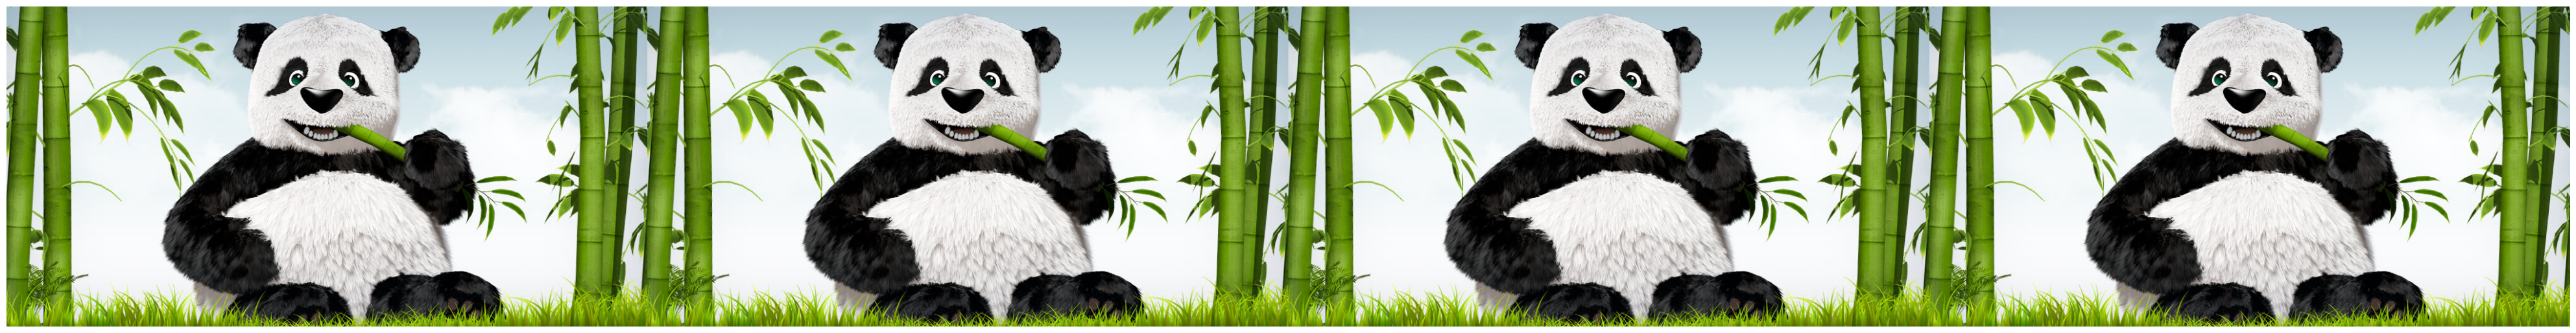

In [11]:
plot_images(panda_images[:4], n_rows=1, figscale=10)

## ADA forward pass results

we can use the `AdaptiveDiscriminatorAugmentation` API with the default list of augmentations or using a custom list, starting with the default ones in this example

In [12]:
default_ada = AdaptiveDiscriminatorAugmentation()

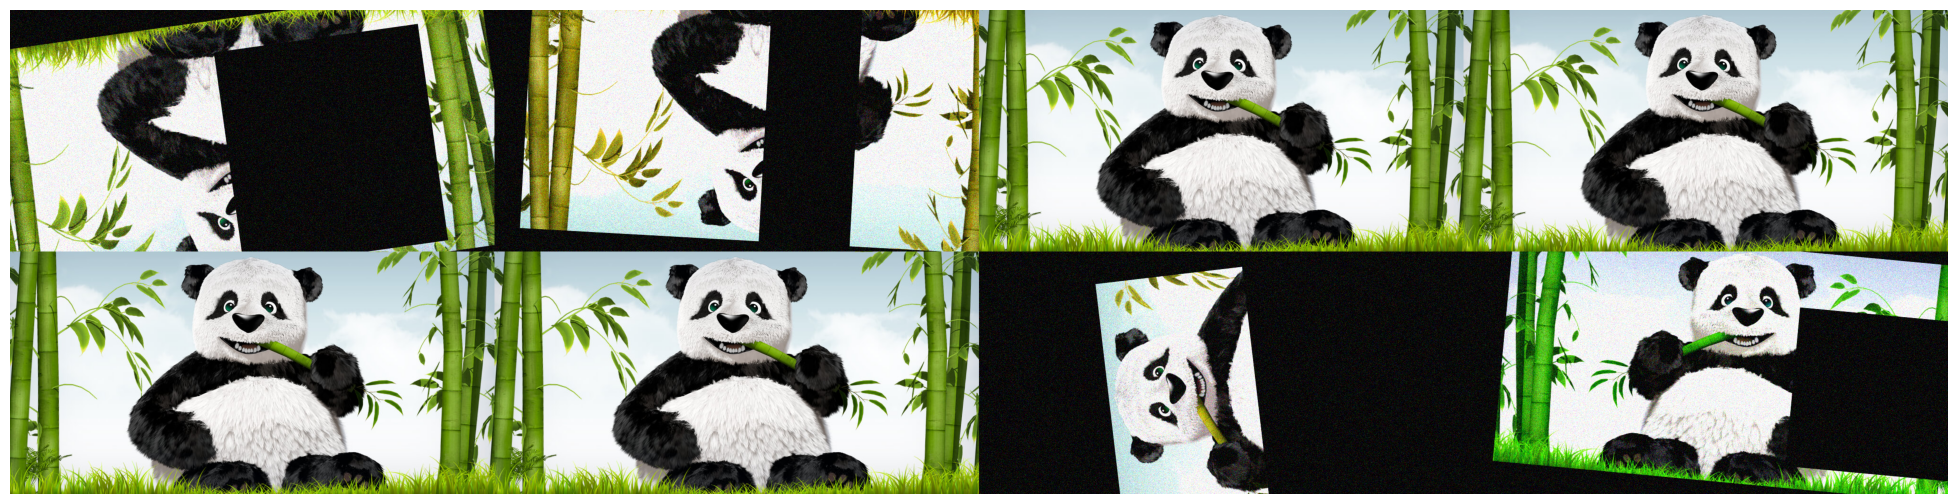

In [14]:
default_ada.p = 0.5
augmented_panda_images = default_ada(panda_images)
plot_images(augmented_panda_images, n_rows=2, figscale=20)

In [15]:
custom_ada = AdaptiveDiscriminatorAugmentation(
    K.RandomChannelShuffle(p=1.0, keepdim=True),
    K.RandomEqualize(p=1.0, keepdim=True),
    K.RandomHorizontalFlip(p=0.5),
    K.ColorJitter(0.15, 0.25, 0.25, 0.25),
)
custom_ada.p = 0.5

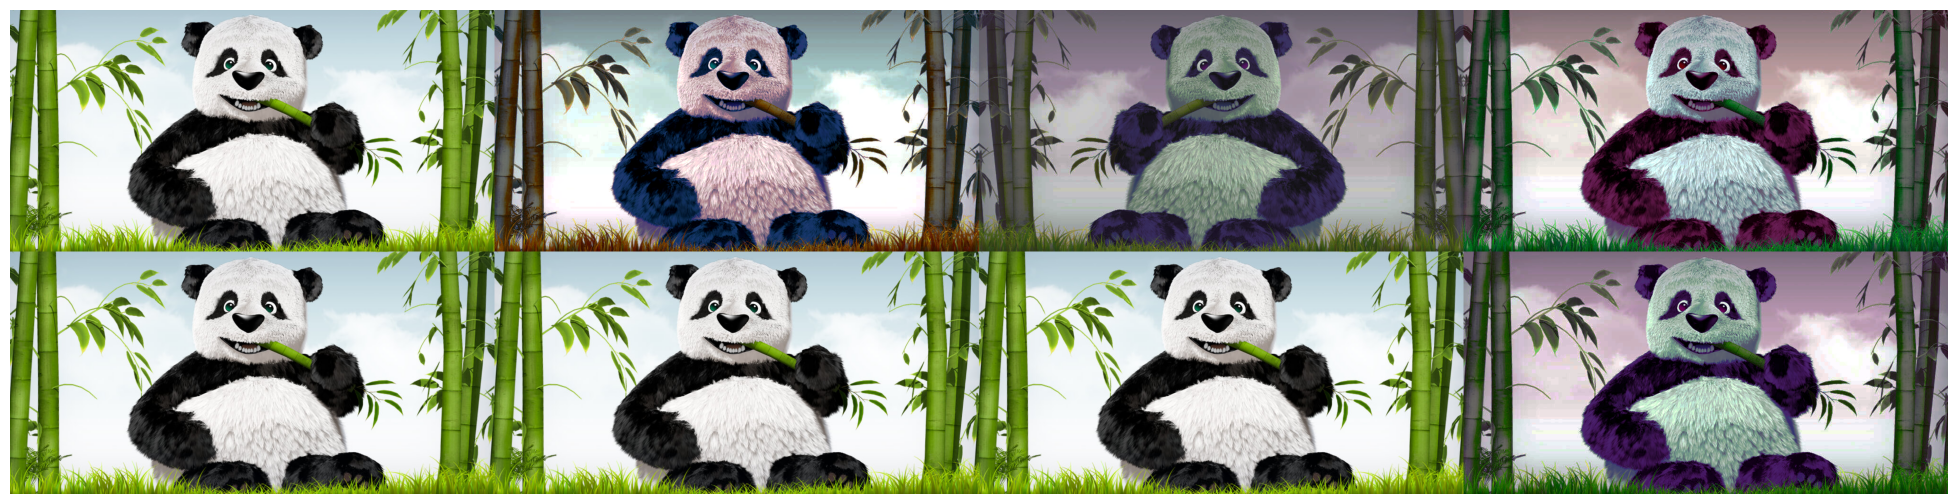

In [21]:
augmented_panda_images = custom_ada(panda_images)
plot_images(augmented_panda_images, n_rows=2, figscale=20)

## Training a simple Generative Adversarial Network (GAN) with ADA

**note:** this implementation isn't meant or optimized to generate high quality images but rather tuned to demonstrate the ADA updates during training with minimal compute, memory and time  
tho the following training loop may run on CPU in a relatively reasonable time, we highly recommend running on a GPU if available

In [22]:
class Generator(nn.Module):
    def __init__(self, lat_dim=64, init_channels=64):
        super().__init__()
        self.lat_dim = lat_dim
        self.init_channels = init_channels

        self.fc = nn.Linear(lat_dim, init_channels * 8 * 1 * 2)

        block1 = self._block(init_channels * 8, init_channels * 4)  # 1x2 -> 4x8
        block2 = self._block(init_channels * 4, init_channels * 2)  # 4x8 -> 16x32
        block3 = self._block(init_channels * 2, init_channels)  # 16x32 -> 64x128

        self.blocks = nn.Sequential(block1, block2, block3)
        self.final_conv = nn.Conv2d(init_channels, 3, kernel_size=3, padding=1)
        self.activation = nn.Tanh()

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=4, mode="bilinear", align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, z):
        x = self.fc(z).view(z.size(0), self.init_channels * 8, 1, 2)
        x = self.blocks(x)
        x = self.final_conv(x)
        return self.activation(x)

In [23]:
class Discriminator(nn.Module):
    def __init__(self, init_channels=64):
        super().__init__()
        self.init_channels = init_channels

        self.initial_conv = nn.Conv2d(3, init_channels, kernel_size=3, padding=1)

        block1 = self._block(init_channels, init_channels * 2)  # 64x128 -> 32x64
        block2 = self._block(init_channels * 2, init_channels * 4)  # 32x64 -> 16x32

        self.blocks = nn.Sequential(block1, block2)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
            nn.Linear(init_channels * 4 * 4 * 4, 1),
        )

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, img):
        x = self.initial_conv(img)
        x = self.blocks(x)
        out = self.classifier(x)
        return out

In [24]:
def create_batch(images_folder):
    images = []
    for image_file in os.listdir(images_folder):
        image = kornia.io.load_image(os.path.join(images_folder, image_file))
        image = (image.float() / 0.5) - 1  # normalizing to be in (-1, 1) as the generator output
        images.append(image)
    batch = torch.stack(images, dim=0)
    return batch

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

G = Generator(lat_dim=64).to(device)
D = Discriminator().to(device)

opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=36e-7, betas=(0.5, 0.999))
criterion = nn.BCEWithLogitsLoss()

real_images = create_batch("pandas")
real_images = real_images.to(device)

real_labels = torch.ones(real_images.size(0), 1).to(device)
fake_labels = torch.zeros(real_images.size(0), 1).to(device)


z = torch.randn(4, 64).to(device)
fake_images = G(z)
print(fake_images.shape)

output = D(fake_images)
print(output.shape)

torch.Size([4, 3, 64, 128])
torch.Size([4, 1])


given the nature of the experiment we're running: looping on a single batch of size 16  
- adjustment speed is set to a slightly high value
- `p` is updated each step
- target real accuracy for the *Discriminator* to maintain is 0.6
- the exponentially moving average lambda set to `0.5` to have an observable evolution of `p` over relatively few steps

In [147]:
ada = AdaptiveDiscriminatorAugmentation(
    # you can pass the custom augmentations you want to use here,
    adjustment_speed=0.05,
    update_every=1,
    target_real_acc=0.6,
    ema_lambda=0.5,
)

in the training loop we apply ADA on both generated and real images, yet we only pass the current `real_acc` value once per step: we update `p` once per step (eather with real or generated images)

In [148]:
lat_dim = 64
epochs = 480

real_acc = None
real_acc_history = []
ada_p_history = []

pbar = tqdm(range(1, epochs + 1))
for epoch in pbar:
    opt_D.zero_grad()
    opt_G.zero_grad()

    perm = torch.randperm(real_images.size(0))
    real_imgs = real_images[perm].to(device)
    real_imgs = ada(real_imgs)

    real_logits = D(real_imgs)
    loss_real = criterion(real_logits, real_labels)

    # Discriminator step
    noise = torch.randn(real_imgs.size(0), lat_dim).to(device)
    fake_imgs = G(noise)
    fake_imgs = ada(fake_imgs, real_acc=real_acc)
    fake_logits = D(fake_imgs.detach())
    loss_fake = criterion(fake_logits, fake_labels)

    D_loss = loss_real + loss_fake
    D_loss.backward()
    opt_D.step()

    fake_acc = (fake_logits < 0).float().mean().item()
    real_acc = (real_logits > 0).float().mean().item()

    # Generator step
    pred_fake = D(fake_imgs)
    G_loss = criterion(pred_fake, real_labels)
    G_loss.backward()
    opt_G.step()

    real_acc_history.append(real_acc)
    ada_p_history.append(ada.p)
    pbar.set_postfix(
        D_loss=f"{D_loss.item():.4f}",
        G_loss=f"{G_loss.item():.4f}",
        real_acc=f"{real_acc:.4f}",
        fake_acc=f"{fake_acc:.4f}",
        p=ada.p,
    )

100%|██████████| 480/480 [00:48<00:00,  9.95it/s, D_loss=1.3424, G_loss=0.7023, fake_acc=0.6875, p=0.45, real_acc=0.8750]


plotting a smoothed line plot of the `real_acc` and `p` values over the training steps with a straight line at the `target real accuracy`

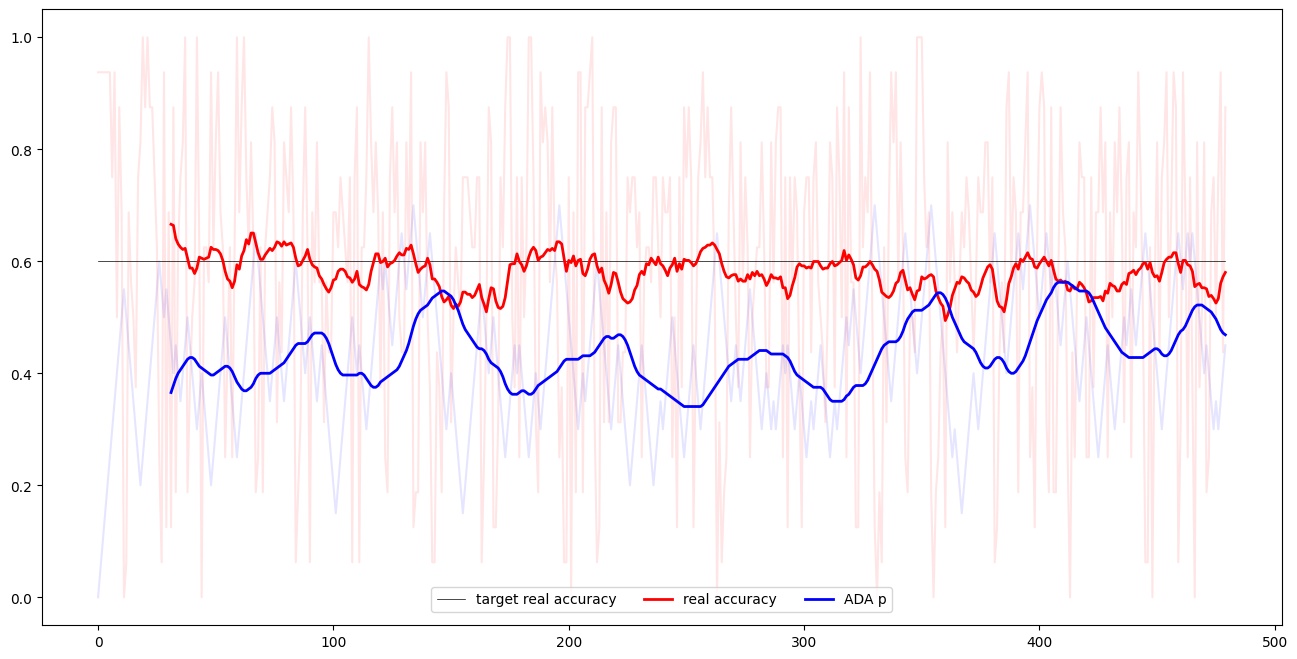

In [149]:
window = 32
steps = np.arange(len(real_acc_history))
smoothed_steps = steps[window - 1 :]

smoothed_real_acc = np.convolve(real_acc_history, np.ones(window) / window, mode="valid")
smoothed_ada_p = np.convolve(ada_p_history, np.ones(window) / window, mode="valid")
target_acc_line = (
    np.ones_like(
        steps,
    )
    * ada.target_real_acc
)

plt.figure(figsize=(16, 8))
plt.plot(steps, ada_p_history, color="blue", alpha=0.1)
plt.plot(steps, real_acc_history, color="red", alpha=0.1)

plt.plot(steps, target_acc_line, color="black", label="target real accuracy", linewidth=0.5)
plt.plot(smoothed_steps, smoothed_real_acc, color="red", label="real accuracy", linewidth=2)
plt.plot(smoothed_steps, smoothed_ada_p, color="blue", label="ADA p", linewidth=2)
plt.legend(
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, 0.01),
)

it's clear to notice that the *Discriminator*'s accuracy identifying real images **hovered** around the target value we set, dynamically enforced by image augmentations governed by `p`